In [1]:
import tifffile as tf
from scipy import ndimage
from scipy import spatial
import numpy as np
import pandas as pd

import os
import glob
import itertools as it
from importlib import reload

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from mvee import EllipsoidTool as ET

In [3]:
wsrc = '../clean2/'
tsrc = '../watershed/'
rsrc = '../rotated/'
dst = '../traditional/'

fs = 15
resol = 0.0759

mborder = ndimage.generate_binary_structure(3, 1).astype(int)
mborder[mborder == 1] = -1
mborder[1,1,1] = -np.sum(mborder) - 1

walnut_batch = sorted(glob.glob( wsrc + '*/' ))
bidx = 2
walnut_files = sorted(glob.glob(walnut_batch[bidx] + '*.tif'))

bname = walnut_batch[bidx].split('/')[-2]

wdst = dst + bname + '/'
if not os.path.isdir(wdst):
    os.makedirs(wdst)
print(wdst)

../traditional/2014SBa_R5_T49/


In [4]:
widx = -1
print(walnut_files[widx])

pa, fi = os.path.split(walnut_files[widx])
fname = os.path.splitext(fi)[0]
print(fname)

tissuefiles = sorted(glob.glob(tsrc + bname + '/' + fname + '_*.tif'))

img = tf.imread(walnut_files[widx])

if True:
    air  = tf.imread(tissuefiles[0])
    meat = tf.imread(tissuefiles[1])
    shell= tf.imread(tissuefiles[2])
    vein = tf.imread(tissuefiles[3])

mxval = 2**(8*img.itemsize)

../clean2/2014SBa_R5_T49/2014SBa_R5_T49_009.tif
2014SBa_R5_T49_009


### Load rotations and phenotypes

In [5]:
filename = rsrc + bname + '/' + fname + '_rotation.csv'
data = np.loadtxt(filename, delimiter=',')

In [6]:
wmean = data[0]
rotxyz = data[10:13]
tipvox = data[14]
rtipvox = data[15]
feretd = data[18]
nutvol, nutarea, nutvoxarea = data[19]
chnutarea, chnutvol, _ = data[20]

In [7]:
chnutaratio = chnutarea/nutarea
chnutvratio = chnutvol/nutvol

In [8]:
print('Nut volume:\t', np.round(nutvol, 2), 'mm^3')
print('Approx by a box of size:\t', np.round(np.cbrt(nutvol),2), 'mm')

Nut volume:	 21681.11 mm^3
Approx by a box of size:	 27.88 mm


### Other phenotypes

In [9]:
nutva3d = (nutarea ** 3)/(36*np.pi*nutvol**2)
nutferet = np.max(feretd)/np.min(feretd)
nutsphr = np.cbrt(36 * np.pi * nutvol**2)/nutarea
shellrug = 1./nutsphr

In [10]:
tvols = np.zeros(4)
for i,tissue in enumerate([air, meat, shell, vein]):
    tvols[i] = np.sum(tissue > 0)

tvols *= resol**3
tvolr = tvols/nutvol
print(np.round(tvolr*100,2), np.sum(tvolr), sep='\n')

[33.05 41.66 15.2  10.09]
0.9999997579945734


### Kernel lobeyness

In [11]:
bimg = meat.copy().astype(int)
bimg[bimg > 0]  = 1
border = ndimage.convolve(bimg, mborder, mode='constant', cval=0)
border[border < 0] = 0
kerarea = np.sum(border) * (resol ** 2)
border[border > 0] = 1
kervoxarea = np.sum(border)

print('Border made of\t', kervoxarea, 'pixels\n')
print('Nut surface area:\t', np.round(kerarea, 2), 'mm^2')
print('Approx by a square of size:\t', np.round(np.sqrt(kerarea),2), 'mm')

Border made of	 906695 pixels

Nut surface area:	 8830.03 mm^2
Approx by a square of size:	 93.97 mm


In [12]:
datapoints = np.asarray(np.nonzero(border))
datapoints = datapoints - wmean.reshape(-1,1)
datapoints *= resol

mcoords = rotxyz @ datapoints

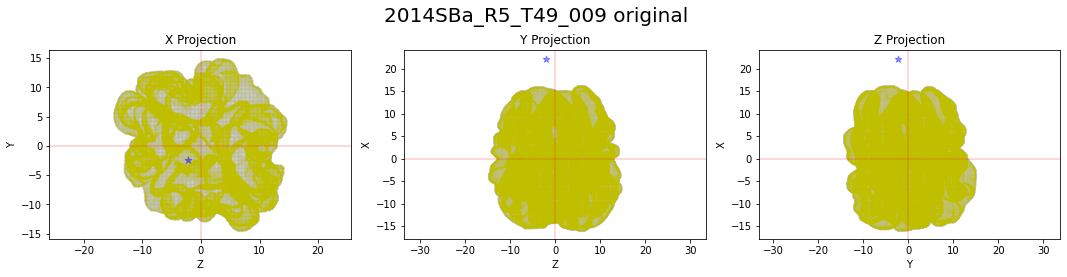

In [14]:
fig, ax = wnut.plot_3Dprojections(datapoints, fname + ' original', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(tipvox[2], tipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(tipvox[2], tipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(tipvox[1], tipvox[0], marker='*', s=50, c='b', alpha=.4);

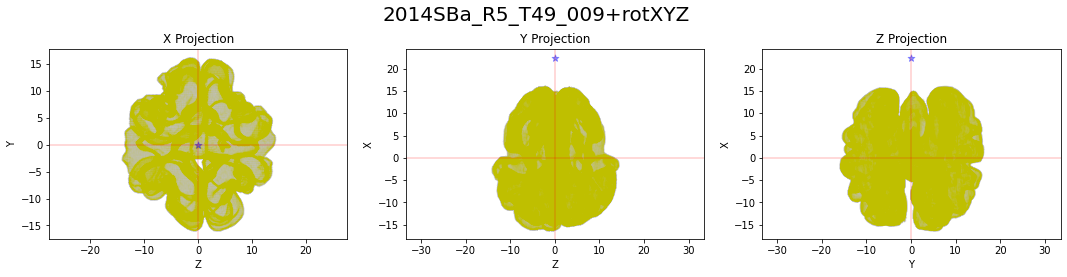

In [15]:
fig, ax = wnut.plot_3Dprojections(mcoords, fname + '+rotXYZ', alpha=0.01, writefig=False, dst=wdst);
ax[0].scatter(rtipvox[2], rtipvox[1], marker='*', s=50, c='b', alpha=.4)
ax[1].scatter(rtipvox[2], rtipvox[0], marker='*', s=50, c='b', alpha=.4)
ax[2].scatter(rtipvox[1], rtipvox[0], marker='*', s=50, c='b', alpha=.4);

In [16]:
kminis = np.min(mcoords, axis=1)
kmaxes = np.max(mcoords, axis=1)
print(kmaxes - kminis)

[32.27562666 31.97963245 28.39080344]


In [17]:
khull = spatial.ConvexHull(mcoords.T)
kerlob = khull.area/kerarea
chkervratio = khull.volume/tvols[1]
print(kerlob, 1/kerlob, sep='\t')

0.3522689547004165	2.83874007816113


### Shell thickness

In [18]:
shelldist = ndimage.distance_transform_cdt(shell, 'taxicab')
cval = np.max(shelldist)

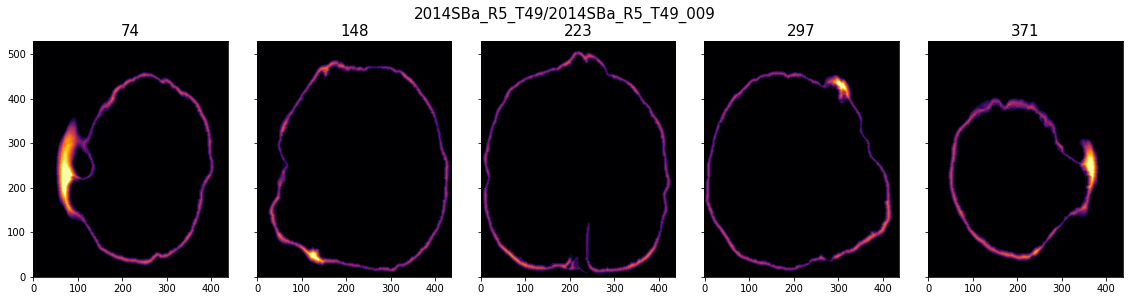

In [19]:
thrs = (np.linspace(0,shell.shape[1],7).astype(int))[1:-1]
ssp = [np.s_[:,t,:] for t in thrs]

fig, ax = plt.subplots(1,len(thrs),figsize=(16,4), sharex=True, sharey=True)

for i in range(len(thrs)):
    ax[i].imshow(shelldist[ssp[i]], cmap='inferno', origin='lower', vmax = cval//2)
    ax[i].set_title(thrs[i], fontsize=fs)
    
fig.suptitle(bname + '/' + fname, fontsize=fs)

fig.tight_layout()

In [20]:
dists = shelldist[shelldist > 2]
sthick = 2*np.mean(dists)
print(sthick)
print(sthick*resol)

10.541379795820975
0.8000907265028119


# Data saving

In [21]:
tradpheno = np.hstack((feretd,
                       nutvol,
                       nutva3d,
                       nutferet,
                       1./nutferet,
                       nutarea,
                       nutsphr,
                       chnutarea,
                       chnutvol,
                       chnutaratio,
                       chnutvratio,
                       1./chnutaratio,
                       1./chnutvratio,
                       tvols,
                       tvolr,
                       shellrug,
                       sthick*resol,
                       kmaxes - kminis,
                       kerarea,
                       khull.volume,
                       khull.area,
                       kerlob,
                       1./kerlob,
                       chkervratio,
                       1./chkervratio))
print(tradpheno.shape)

filename = wdst + fname + '_trad.csv'
foo = pd.DataFrame([bname, fname.split('_')[-1], *tradpheno]).T
foo.to_csv(filename, header=False, index=False)

(35,)


In [22]:
bar = pd.read_csv(filename, header=None, dtype={1:str})

In [23]:
bar

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,2014SBa_R5_T49,009,40.345169,35.942313,34.074732,21681.107844,5.010225,1.18402,0.84458,6434.144994,...,32.275627,31.979632,28.390803,8830.031309,15483.344475,3110.545899,0.352269,2.83874,1.714185,0.583368
